In [42]:
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [43]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./face_landmark.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_details, output_details

([{'name': 'input_1',
   'index': 0,
   'shape': array([  1, 192, 192,   3], dtype=int32),
   'shape_signature': array([  1, 192, 192,   3], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}],
 [{'name': 'conv2d_20',
   'index': 213,
   'shape': array([   1,    1,    1, 1404], dtype=int32),
   'shape_signature': array([   1,    1,    1, 1404], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}},
  {'name': 'conv2d_30',
   'index': 210,
   'shape': array([1, 1, 1, 1], dtype=int32),
   'shape_signature': array([1, 1, 1, 1], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_param

In [44]:
# Load and process image
def process_input(img_path, new_w, new_h):
    img = Image.open(img_path)
    img = img.resize((new_w, new_h))
    return img


# Inference on image
def inference_facemesh(img_path):
    interpreter = tf.lite.Interpreter(model_path='face_landmark.tflite')
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    floating_model = input_details[0]['dtype'] == np.float32

    req_height = input_details[0]['shape'][1]
    req_width = input_details[0]['shape'][2]
    img = process_input(img_path, req_width, req_height)
    input_data = np.expand_dims(img, axis=0)

    if floating_model:
        input_data = (np.float32(input_data) - 127.5) / 127.5

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    results = np.squeeze(output_data)
    results.shape = (468, 3)

    return results


def display_image(face_mesh_result, img_path):
    plt.imshow(process_input(img_path , 192, 192), zorder=1)
    x, y = face_mesh_result[:, 0], face_mesh_result[:, 1]
    plt.scatter(x, y, zorder=2, s=1.0)
    plt.show()
    
def process_input(img_path, new_w=192, new_h=192, img_format='pil_image'):
    if img_format == 'pil_image':
        img = Image.open(img_path)
        img = img.resize((new_w, new_h))

    if img_format == 'cv2':
        img = cv2.imread(img_path)
        img = cv2.resize(img, (new_w, new_h))

    return img

def process_landmark_points(face_mesh_result):
    landmark_points_org = face_mesh_result[:, 0:2]
    landmark_points_org = [
        list(map(int, i)) for i in landmark_points_org
    ]
    landmark_points_tuple = [tuple(i) for i in landmark_points_org]
    landmark_points_arr = np.array(landmark_points_tuple, np.int32)
    
    return landmark_points_tuple,landmark_points_arr

def rect_around_triangle(points_list):
    triangle = np.array(points_list, np.int32)
    rect = cv2.boundingRect(triangle)
    return rect


In [45]:
# test_image_path = './test.jpg'
# face_mesh_result = inference_facemesh(test_image_path)
# display_image(face_mesh_result, test_image_path)

In [46]:
source_path = './bradley_cooper.jpg'
target_path = './jim_carrey.jpg'

source_mesh_results = inference_facemesh(source_path)
target_mesh_results = inference_facemesh(target_path)

# display_image(source_mesh_results, source_path)
# display_image(target_mesh_results, target_path)

In [48]:
source_mesh_results[0]

array([ 84.55849 , 110.10008 , -12.642598], dtype=float32)

In [10]:
source_landmark_points_tuple, source_landmark_points_arr = process_landmark_points(
    source_mesh_results)
target_landmark_points_tuple, target_landmark_points_arr = process_landmark_points(
    target_mesh_results)

source_convex_hul = cv2.convexHull(source_landmark_points_arr)
target_convex_hul = cv2.convexHull(target_landmark_points_arr)

In [11]:
# original image , gray image, and mask
source_img = process_input(source_path,img_format='cv2')
source_img_gray = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)
source_img_mask = np.zeros_like(source_img_gray)

target_img = process_input(target_path,img_format='cv2')
target_img_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)
target_img_mask = np.zeros_like(target_img_gray)

In [12]:
# # For visualization

# cv2.polylines(source_img,[source_convex_hul],True,(255,0,0),3) # draws a boundary convex hull around face
# cv2.fillConvexPoly(source_img_mask,source_convex_hul,255) # fill area inside convex hull of mask with 255

# face_image_1 = cv2.bitwise_and(source_img, source_img, mask=source_img_mask)
# cv2.imshow("Image 1", source_img)
# cv2.imshow("Face image 1", face_image_1)
# cv2.imshow("Mask", source_img_mask)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [13]:
# Delaunav Triangulation for source face
rect = cv2.boundingRect(
    source_convex_hul
)  # returns rectangle sourrouding the convexhull (x,y,w,h)
subdiv = cv2.Subdiv2D(
    rect
)  # this is a builtin function in opencv to find Delaunav triangulation
subdiv.insert(source_landmark_points_tuple)  # insert the points as tuple
triangles_source_face = subdiv.getTriangleList(
)  # returns the triangle from image (3 point of x,y)
triangles_source_face = np.array(triangles_source_face, dtype=np.int32)

#get the corresponding index from the landmark_points_arr
#this index will be used to get the values from the target_face

triangles_source_face_index = []
for t in triangles_source_face:
    pt1 = (t[0], t[1])
    pt1_index = np.where((source_landmark_points_arr == pt1).all(axis=1))[0][0]
    pt2 = (t[2], t[3])
    pt2_index = np.where((source_landmark_points_arr == pt2).all(axis=1))[0][0]
    pt3 = (t[4], t[5])
    pt3_index = np.where((source_landmark_points_arr == pt3).all(axis=1))[0][0]
    triangles_source_face_index.append([pt1_index, pt2_index, pt3_index])

    # For visualization
#     cv2.line(source_img, pt1, pt2, (0, 0, 255), 2)
#     cv2.line(source_img, pt2, pt3, (0, 0, 255), 2)
#     cv2.line(source_img, pt1, pt3, (0, 0, 255), 2)

# cv2.imshow("Image 1", source_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [14]:
# # For visualization
# x,y,w,h = rect
# cv2.rectangle(source_img,(x,y),(x+w,y+h),(0,255,0))
# cv2.imshow("Image 1", source_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [15]:
# eval('source_' + str('landmark_points_arr'))

In [16]:
# # For visualization 
# # Triangulation of target face using the source face

# for triangle_index in triangles_source_face_index:
#     # Triangulation Source Face
#     tr1_pt1 = tuple(source_landmark_points_arr[triangle_index[0]])
#     tr1_pt2 = tuple(source_landmark_points_arr[triangle_index[1]])
#     tr1_pt3 = tuple(source_landmark_points_arr[triangle_index[2]])

#     (x, y, w, h) = rect_around_triangle([tr1_pt1, tr1_pt2, tr1_pt3])
#     cropped_triangle_source = source_img[y:y + h, x:x + w]

#     cropped_triangle1_mask = np.zeros((h, w), np.uint8)
#     points1 = np.array(
#         [[tr1_pt1[0] - x, tr1_pt1[1] - y], [tr1_pt2[0] - x, tr1_pt2[1] - y],
#          [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)
#     cv2.fillConvexPoly(cropped_triangle1_mask, points1, 255)
#     cropped_triangle_source = cv2.bitwise_and(cropped_triangle_source,
#                                         cropped_triangle_source,
#                                         mask=cropped_triangle1_mask)

#     # Triangulation Target Face
#     tr2_pt1 = tuple(target_landmark_points_arr[triangle_index[0]])
#     tr2_pt2 = tuple(target_landmark_points_arr[triangle_index[1]])
#     tr2_pt3 = tuple(target_landmark_points_arr[triangle_index[2]])

#     (x, y, w, h) = rect_around_triangle([tr2_pt1, tr2_pt2, tr2_pt3])
#     cropped_triangle_target = target_img[y:y + h, x:x + w]

#     cropped_triangle2_mask = np.zeros((h, w), np.uint8)
#     points2 = np.array(
#         [[tr2_pt1[0] - x, tr2_pt1[1] - y], [tr2_pt2[0] - x, tr2_pt2[1] - y],
#          [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)
#     cv2.fillConvexPoly(cropped_triangle2_mask, points2, 255)
#     cropped_triangle_target = cv2.bitwise_and(cropped_triangle_target,
#                                         cropped_triangle_target,
#                                         mask=cropped_triangle2_mask)
    
#     points1 = points1.astype(np.float32)
#     points2 = points2.astype(np.float32)
#     M = cv2.getAffineTransform(points1, points2)
#     warped_triangle = cv2.warpAffine(cropped_triangle_source, M, (w, h))
#     break
    
# cv2.imshow("Image 1", warped_triangle)
# cv2.imshow("Image 2", cropped_triangle_target)
# cv2.imshow("Image 3", cropped_triangle_source)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [17]:
# select a rect around each triangle for both the face
# create the mask and extract the triangle for both the face
# now using affine transform warp the triangle from source face to target face

In [31]:
# Triangulation 
new_target_face = np.zeros_like(target_img) 

for triangle_index in triangles_source_face_index:

    ################ Triangulation Source Face ################
    # get triangle index
    tr1_pt1 = tuple(source_landmark_points_arr[triangle_index[0]])
    tr1_pt2 = tuple(source_landmark_points_arr[triangle_index[1]])
    tr1_pt3 = tuple(source_landmark_points_arr[triangle_index[2]])
    
    # get rect around triangle
    (x, y, w, h) = rect_around_triangle([tr1_pt1, tr1_pt2, tr1_pt3])
    cropped_triangle_source = source_img[y:y + h, x:x + w]
    # create a mask same size of rect
    cropped_triangle1_mask = np.zeros((h, w), np.uint8)
    points1 = np.array(
        [[tr1_pt1[0] - x, tr1_pt1[1] - y], [tr1_pt2[0] - x, tr1_pt2[1] - y],
         [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)
    cv2.fillConvexPoly(cropped_triangle1_mask, points1, 255)
    # this filters out the triangular part of the image using the mask
    cropped_triangle_source = cv2.bitwise_and(cropped_triangle_source,
                                              cropped_triangle_source,
                                              mask=cropped_triangle1_mask)

    ################ Triangulation Target Face ################
    tr2_pt1 = tuple(target_landmark_points_arr[triangle_index[0]])
    tr2_pt2 = tuple(target_landmark_points_arr[triangle_index[1]])
    tr2_pt3 = tuple(target_landmark_points_arr[triangle_index[2]])
    
    # get rect around triangle
    (x, y, w, h) = rect_around_triangle([tr2_pt1, tr2_pt2, tr2_pt3])
    cropped_triangle_target = target_img[y:y + h, x:x + w]
    # create a mask same size of rect
    cropped_triangle2_mask = np.zeros((h, w), np.uint8)
    points2 = np.array(
        [[tr2_pt1[0] - x, tr2_pt1[1] - y], [tr2_pt2[0] - x, tr2_pt2[1] - y],
         [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)
    cv2.fillConvexPoly(cropped_triangle2_mask, points2, 255)
    # this filters out the triangular part of the image using the mask
    cropped_triangle_target = cv2.bitwise_and(cropped_triangle_target,
                                              cropped_triangle_target,
                                              mask=cropped_triangle2_mask)
    # warped using affine transform
    points1 = points1.astype(np.float32)
    points2 = points2.astype(np.float32)
    M = cv2.getAffineTransform(points1, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle_source, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_triangle2_mask)
    
    # Reconstructing destination face
    new_target_face_rect_area = new_target_face[y: y + h, x: x + w]
    new_target_face_rect_area_gray = cv2.cvtColor(new_target_face_rect_area, cv2.COLOR_BGR2GRAY)
    
    # Let's create a mask to remove the lines between the triangles
    _, mask_triangles_designed = cv2.threshold(new_target_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)
    img2_new_face_rect_area = cv2.add(new_target_face_rect_area, warped_triangle)
    new_target_face[y: y + h, x: x + w] = img2_new_face_rect_area

In [32]:
cv2.imshow("'new_target_face",new_target_face)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [33]:
# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(target_img_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, target_convex_hul, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)
img2_head_noface = cv2.bitwise_and(target_img, target_img, mask=img2_face_mask)
result = cv2.add(img2_head_noface, new_target_face)

(x, y, w, h) = cv2.boundingRect(target_convex_hul)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, target_img, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

cv2.imshow("seamlessclone",seamlessclone)
# cv2.imshow("result",result)
# cv2.imshow("image2",img_1)
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [36]:
median = cv2.medianBlur(seamlessclone,3)
cv2.imshow("'new_target_face",median)
cv2.waitKey(0)
cv2.destroyAllWindows()

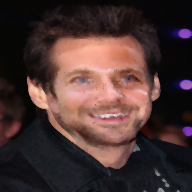

In [41]:
img = cv2.cvtColor(median, cv2.COLOR_BGR2RGB)
Image.fromarray(img)